# 3D Conformation Prediction

In [3]:
import pandas as pd
import numpy as np
import os
import glob
import torch
import torch.nn.functional as F
from tqdm import tqdm
from rdkit.Chem import MolFromSmiles

In [3]:
from IPython import get_ipython

def tqdm_clear(*args, **kwargs):
    from tqdm import tqdm
    getattr(tqdm, '_instances', {}).clear()

get_ipython().events.register('post_execute', tqdm_clear)

## Load QM9

In [148]:
file_re = os.path.join('./qm92', '*.xyz')
file_pathes = glob.glob(file_re)
file_pathes.sort()
ls = []
_smiles_column_names = ['smiles1', 'smiles2']
_label_names = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
                'zpve', 'U0', 'U', 'H', 'G', 'Cv']

y = []
for ix,path in enumerate(tqdm(file_pathes)):
    with open(path, 'r') as f:
        data = [line.strip() for line in f]
        
    num_atom = int(data[0])
    # We're only interested in molecules with 3 or more molecules
    if num_atom < 3:
        continue
    properties = list(map(float, data[1].split('\t')[1:]))
    ys = []
    for ix_pos in range(2,num_atom+2):
        if not data[ix_pos][0] == 'H':
            ys.append(list(map(float, data[ix_pos].replace('*^', 'e').split('\t')[1:]))[:3])

    if len(ys) < 3:
        continue
    y.append(ys)

    smiles = data[3 + num_atom].split('\t')
    new_ls = smiles + properties
    ls.append(new_ls)

df = pd.DataFrame(ls, columns= _smiles_column_names + _label_names)

100%|██████████| 133885/133885 [00:06<00:00, 19880.71it/s]


In [149]:
df.sample(5)

,smiles1,smiles2,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
30819,CCC1=C(O)C=C(N)O1,CCc1c(O)cc(N)o1,2.26655,1.36672,0.89989,2.4617,77.60,-0.1693,0.0457,0.2151,1300.6028,0.146661,-439.115053,-439.105337,-439.104393,-439.149867,35.128
95160,CC1COC2CC2(C)O1,C[C@H]1CO[C@H]2C[C@@]2(C)O1,2.50131,1.55394,1.13491,0.6025,78.69,-0.2249,0.0833,0.3082,1160.8802,0.181624,-424.212783,-424.203893,-424.202949,-424.245864,34.607
91502,CC1CC2CC12C(C)=O,C[C@H]1C[C@H]2C[C@@]12C(=O)C,2.43643,1.41314,1.09871,2.8781,83.69,-0.2356,-0.0105,0.2251,1203.5310,0.181090,-387.094134,-387.084762,-387.083818,-387.128374,35.243
59371,CC(O)C1CC(O1)C#C,C[C@@H](O)[C@H]1C[C@@H](O1)C#C,4.34364,0.88978,0.84662,1.2779,78.24,-0.2596,0.0176,0.2773,1414.6481,0.157097,-422.974569,-422.965105,-422.964161,-423.009265,35.136
19960,CC1COC1C1CN1,C[C@H]1CO[C@H]1[C@H]1CN1,3.43958,1.73584,1.41605,2.0377,70.53,-0.2407,0.0733,0.3140,950.5804,0.166501,-365.016298,-365.008323,-365.007379,-365.048946,29.435


In [150]:
df.loc[200]

smiles1     OC1=CNC=C1
smiles2    Oc1c[nH]cc1
A              8.97547
B              3.51643
C              2.52657
mu              1.6811
alpha            47.51
homo           -0.1864
lumo              0.05
gap             0.2364
r2             480.403
zpve          0.086407
U0            -285.316
U             -285.311
H              -285.31
G             -285.345
Cv              19.995
Name: 200, dtype: object

# Setting up dataset

The first thing we want to do is to find a way of representing a molecule to our graph convolutional network. For this, we will make use of DeepChem which provides a number of 'featurizers'. In this case the features of an atom is a number of descriptors generated from RDKit.

In [151]:
mols = [MolFromSmiles(row.smiles1) for (ix,row) in df.iterrows()]

### Adding Fingerprints to the mix

In [152]:
from rdkit.Chem import AllChem
fingerprints = []
for m in mols:
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m, useChirality=True, radius=2, nBits=1024)
    vec1 = np.array(fp1);
    fingerprints.append(vec1)

### Looking at graph representations

In [153]:
import networkx as nx

def create_edge_index(A):
    rows = []
    cols = []
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if A[i,j] == 1:
                rows.append(i)
                cols.append(j)
    return rows, cols

def get_molecule_features(m):
    featurizer = ConvMolFeaturizer()
    return featurizer.featurize([m])[0].get_atom_features()

In [154]:
from deepchem.feat import RDKitDescriptors, ConvMolFeaturizer
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

m = mols[200]
molecule_featurized = get_molecule_features(m)
A = GetAdjacencyMatrix(m)

In [155]:
atomlist = [at.GetSymbol() for at in m.GetAtoms()]
atomlist

['O', 'C', 'C', 'N', 'C', 'C']

Let's see how our adjacency matrix looks. This matrix will be used in our graph convolutions.

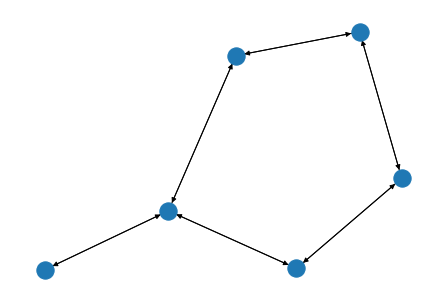

In [156]:
D = nx.to_networkx_graph(A,create_using=nx.DiGraph())
nx.draw(D)

Let's see how the molecule looks in 2D according to RDKit

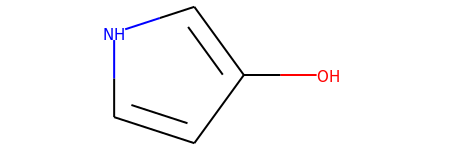

In [157]:
from rdkit.Chem import Draw
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import IPythonConsole
m

Let's repeat this for all molecules

In [158]:
import os.path
import pickle
from torch_geometric.data import Data, DataLoader
from torchvision import transforms

if True:
    data_list = []
    for ix, m in enumerate(mols):
        mol_featurized = get_molecule_features(m)
        A = GetAdjacencyMatrix(m)
        edge_index = create_edge_index(A)
        x = torch.tensor(mol_featurized)
        #x_min = torch.min(x)
        #range_x = torch.max(x) - torch.min(x)
        #x = (x - x_min) / range_x
        if not x.shape[0] == torch.DoubleTensor(y[ix]).shape[0]:
            print("Unmatching x and y!")
            print(x.shape)
            print(torch.DoubleTensor(y[ix]).shape)
            break
        d = Data(x=x, edge_index=torch.LongTensor(edge_index), y=torch.DoubleTensor(y[ix]))
        d.fingerprint = fingerprints[ix]
        d.atom_list = [at.GetSymbol() for at in m.GetAtoms()]
        data_list.append(d)
        
    with open('data_list.pickle', 'wb') as f:
        pickle.dump(data_list, f)
else:
    with open('data_list.pickle', 'rb') as f:
        data_list = pickle.load(f)

In [159]:
loader = DataLoader(data_list, batch_size=32)

# Setting Up Graph Convolutional Network

In [160]:
from torch_geometric.nn import GCNConv, BatchNorm, GMMConv, SAGEConv, GraphConv, GATConv
from torch_geometric.nn.pool import TopKPooling, EdgePooling, SAGPooling
from torch import nn

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GraphConv(75, 256)
        self.conv2 = GraphConv(256, 256)
        self.batch_norm1 = BatchNorm(256)
        self.linear = nn.Linear(256, 128)
        self.linear2 = nn.Linear(1152, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.batch_norm1(x)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.batch_norm1(x)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.batch_norm1(x)
        
        x = self.linear(x)
        
        outs = []
        fp = torch.DoubleTensor(data.fingerprint).to(device)
        for row_ix in range(x.shape[0]):
            z = torch.cat((x[row_ix,:], fp), 0)
            outs.append(self.linear2(z))
        
        return torch.stack(outs)

In [161]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = loader.dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [162]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [163]:
#import random
#random.shuffle(loader.dataset)
N = len(loader.dataset)
num_train = 1000
X_train = loader.dataset[:num_train]
X_val = loader.dataset[num_train:num_train+100]
batch_size = 128
X_train_batched = chunks(X_train, len(X_train) // batch_size)
model.double()

Net(
  (conv1): GraphConv(75, 256)
  (conv2): GraphConv(256, 256)
  (batch_norm1): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=1152, out_features=3, bias=True)
)

In [164]:
model.double()
model.train()
n_epochs = 100
saving_freq = 10

for epoch in range(n_epochs):
    model.train()
    print("===== Epoch %d of %d ====" % (epoch + 1, n_epochs))
    losses = []
    batch_ix = 0
    num_batches = len(X_train) // batch_size
    #random.shuffle(X_train)
    val_loss = 0
    X_train_batched = chunks(X_train, num_batches)
    print(X_train_batched)
    for batch_ix in tqdm(range(num_batches)):
        batch = next(X_train_batched)
        y_hats = []
        ys = []

        for data in batch:
            data.to(device)
            y_hat = model(data)
            y_hats.append(y_hat)
            ys.append(data.y)
            

        y_hats = torch.cat(y_hats)
        ys = torch.cat(ys)

        loss = F.mse_loss(y_hats, ys)
        loss.backward()
        losses.append(loss)
        optimizer.step()
        optimizer.zero_grad()
     
    """
    with torch.no_grad():
        y_hats = []
        ys = []
        
        print("Validation")
        model.eval()
        
        for data in tqdm(X_val):
            data.to(device)
            y_hat = model(data)
            y_hats.append(y_hat)
            ys.append(data.y)
            
        y_hats = torch.cat(y_hats)
        ys = torch.cat(ys)
        
        loss = F.mse_loss(y_hats, ys)
        val_loss = loss.mean()
        
    if epoch % saving_freq == 0:
        torch.save(model.state_dict(), './saved_model/model_%d' % epoch )
    """
    
    print("Training loss: %.4f" % torch.stack(losses).mean())
    #print("Validation loss: %.4f" % val_loss)

torch.save(model.state_dict(), './model_latest')

  0%|          | 0/7 [00:00<?, ?it/s]

===== Epoch 1 of 100 ====
<generator object chunks at 0x7f17e8177150>
Training loss: 0.7238
===== Epoch 2 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.5052
===== Epoch 3 of 100 ====
<generator object chunks at 0x7f17e8177150>
Training loss: 0.4147
===== Epoch 4 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.3383
===== Epoch 5 of 100 ====
<generator object chunks at 0x7f17e8177150>
Training loss: 0.2912
===== Epoch 6 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.2563
===== Epoch 7 of 100 ====
<generator object chunks at 0x7f17e8177150>
Training loss: 0.2359
===== Epoch 8 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.2215
===== Epoch 9 of 100 ====
<generator object chunks at 0x7f17e8177150>
Training loss: 0.2248
===== Epoch 10 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.2472
===== Epoch 11 of 100 ====
<generator object chunks at 0x7f17e8177150>
Training loss: 0.2482
===== Epoch 12 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.2560
===== Epoch 13 of 100 ====
<generator object chunks at 0x7f17e8177150>
Training loss: 0.2354
===== Epoch 14 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.2006
===== Epoch 15 of 100 ====
<generator object chunks at 0x7f17e8177150>
Training loss: 0.1864
===== Epoch 16 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.1745
===== Epoch 17 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.1748
===== Epoch 18 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.1718
===== Epoch 19 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.1720
===== Epoch 20 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.1715
===== Epoch 21 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.1544
===== Epoch 22 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.1457
===== Epoch 23 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.1349
===== Epoch 24 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.1299
===== Epoch 25 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.1256
===== Epoch 26 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.1214
===== Epoch 27 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.1189
===== Epoch 28 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.1170
===== Epoch 29 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.1130
===== Epoch 30 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.1097
===== Epoch 31 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.1077
===== Epoch 32 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.1040
===== Epoch 33 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.1012
===== Epoch 34 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0992
===== Epoch 35 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0974
===== Epoch 36 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0957
===== Epoch 37 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0938
===== Epoch 38 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0920
===== Epoch 39 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0902
===== Epoch 40 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0886
===== Epoch 41 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0870
===== Epoch 42 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0858
===== Epoch 43 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0845
===== Epoch 44 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0830
===== Epoch 45 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0818
===== Epoch 46 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0807
===== Epoch 47 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0800
===== Epoch 48 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0788
===== Epoch 49 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0775
===== Epoch 50 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0765
===== Epoch 51 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0762
===== Epoch 52 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0761
===== Epoch 53 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0750
===== Epoch 54 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0748
===== Epoch 55 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0752
===== Epoch 56 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0740
===== Epoch 57 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0727
===== Epoch 58 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0718
===== Epoch 59 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0710
===== Epoch 60 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0700
===== Epoch 61 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0685
===== Epoch 62 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0677
===== Epoch 63 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0674
===== Epoch 64 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0673
===== Epoch 65 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0673
===== Epoch 66 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0667
===== Epoch 67 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0657
===== Epoch 68 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0649
===== Epoch 69 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0650
===== Epoch 70 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0652
===== Epoch 71 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0644
===== Epoch 72 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0655
===== Epoch 73 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0665
===== Epoch 74 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0645
===== Epoch 75 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0623
===== Epoch 76 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0614
===== Epoch 77 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0618
===== Epoch 78 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0627
===== Epoch 79 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0614
===== Epoch 80 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0606
===== Epoch 81 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0606
===== Epoch 82 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0595
===== Epoch 83 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0582
===== Epoch 84 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0571
===== Epoch 85 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0568
===== Epoch 86 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0564
===== Epoch 87 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0554
===== Epoch 88 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0550
===== Epoch 89 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0548
===== Epoch 90 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0545
===== Epoch 91 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0541
===== Epoch 92 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0540
===== Epoch 93 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0539
===== Epoch 94 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0535
===== Epoch 95 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0536
===== Epoch 96 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0535
===== Epoch 97 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0533
===== Epoch 98 of 100 ====
<generator object chunks at 0x7f17e8060570>


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 0.0533
===== Epoch 99 of 100 ====
<generator object chunks at 0x7f188a8a41a8>
Training loss: 0.0533
===== Epoch 100 of 100 ====
<generator object chunks at 0x7f17e8060570>


100%|██████████| 7/7 [00:00<00:00, 60.38it/s]

Training loss: 0.0529


In [21]:
import ase
import pandas as pd
import numpy as np
from ase import Atoms, Atom
import ase.visualize
import random

In [165]:
model.load_state_dict(torch.load('./model_latest'))
model.eval()

Net(
  (conv1): GraphConv(75, 256)
  (conv2): GraphConv(256, 256)
  (batch_norm1): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=1152, out_features=3, bias=True)
)

In [166]:
curr_mol = 600

In [167]:
x_0 = X_train[curr_mol]
x_0.to(device)
with torch.no_grad():
    y_0_hat = model(x_0)
    y_0 = x_0.y.cpu().numpy()
    
#system = Atoms(positions=y_0_hat.cpu().numpy(), symbols=x_0.atom_list)
#ase.visualize.view(system, viewer="x3d")

system = Atoms(positions=y_0, symbols=x_0.atom_list)
ase.visualize.view(system, viewer="ngl")

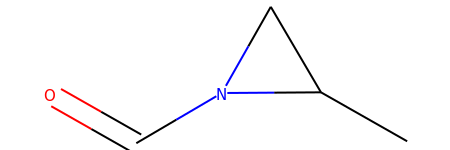

In [168]:
mols[curr_mol].GetNumAtoms()
mols[curr_mol]

In [169]:
system = Atoms(positions=y_0_hat.cpu().numpy(), symbols=x_0.atom_list)
ase.visualize.view(system, viewer="ngl")